# Explaining Away Attacks Against Neural Networks

This notebook accompanies the blog post titled "Explaining Away Attacks Against Neural Networks"
It implements the following:
* Load a pre-trained InceptionV3 model from pytorch
* Generate adversarial examples using an ImageNet image
* Generate explanations for the model's prediction via SHAP
* Compare SHAP value explanations between the original image and the adversarial image

The notebook has been on run using Python 3.6 and relies on the following dependencies:

```
matplotlib==3.1.1
numpy==1.17.0
Pillow==6.1.0
scipy==1.3.0
shap==0.29.3
torch==1.1.0.post2
torchvision==0.3.0
```

In [1]:
# pip install dependencies
# !pip install torch torchvision numpy matplotlib scipy shap pillow

# Imports
import json
import logging
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.special import softmax
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

logging.basicConfig(stream=sys.stdout,
                        level=logging.INFO,
                        format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger(__name__)

fp = open('map_clsloc.txt')
lines = fp.readlines()
fp.close()
lines = [line.split() for line in lines]
dict_model_idx_to_class = {int(idx) - 1: name for (name, idx, _) in lines}
dict_model_idx_to_name = {int(idx) - 1: name for (_, idx, name) in lines}
dict_synset_to_name = {synset: name for (synset, _, name) in lines}
dict_name_to_synset = {name: synset for (synset, _, name) in lines}
with open('dict_class_to_idx.pkl', 'rb') as fp:
    dict_class_to_idx = pickle.load(fp)
dict_idx_to_class = {v:k for (k,v) in dict_class_to_idx.items()}

In [2]:
# Configurations

# Path to the image
image_path = 'elephant.png'

# Size of the input (a square image)
input_size = 224

# The upper bound on perturbations to make to the image
epsilon = 0.01

# Number of iterations to apply FGSM
num_iterations = 20

# Original class of the target image
original_class_name = 'African_elephant'

# The target class of the attack - you can choose any other ImageNet class
# to experiment
target_class_name = 'ping-pong_ball'

# Or, you can play with random classes with the following:
def _get_random_class():
    return np.random.choice(list(dict_name_to_synset.keys()))

# Uncomment the line below to get a random class
# target_class_name = _get_random_class()

original_class_idx = dict_class_to_idx[dict_name_to_synset[original_class_name]]
target_class_idx = dict_class_to_idx[dict_name_to_synset[target_class_name]]

logger.info('Original class: {}'.format(original_class_name))
logger.info('Target class: {}'.format(target_class_name))

2019-08-03 17:13:20,167 __main__     INFO     Original class: African_elephant
2019-08-03 17:13:20,168 __main__     INFO     Target class: ping-pong_ball


In [3]:
# Helper functions (for plotting etc.)

def plot_comparison(result):
    adv_image, clean_image, difference, adv_prob, clean_prob = result
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(18)
    fig.set_figwidth(18)
    adv_image = np.transpose(adv_image, [1, 2, 0])
    clean_image = np.transpose(clean_image, [1, 2, 0])
    
    mi = difference.min()
    ma = difference.max()
    difference = (difference - mi) / (ma - mi)
    difference = np.transpose(difference, [1, 2, 0])
    
    ax1.set_title('Original image: {} ({:.2f}%)'.format(original_class_name, 100*clean_prob), size=17)
    ax1.axis('off')
    ax2.set_title('Noise added (eps: {})'.format(epsilon), size=17)
    ax2.axis('off')
    ax3.set_title('Adversarial image: {} ({:.2f}%)'.format(target_class_name, 100*adv_prob), size=17)
    ax3.axis('off')
    
    ax1.imshow(clean_image)
    ax2.imshow(difference)
    ax3.imshow(adv_image)

In [4]:
# Load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)
    
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info('Using device {}'.format(device))

# Get model
model = models.inception_v3(pretrained=True)
model = model.eval()
model = model.to(device)

2019-08-03 17:13:20,203 __main__     INFO     Using device cpu


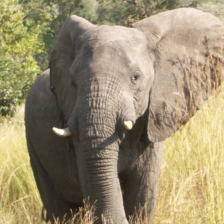

In [5]:
# Load the image
image = Image.open(image_path)
image

(3, 224, 224)


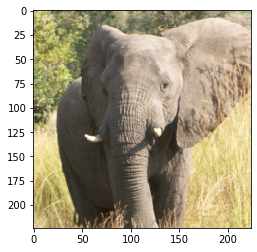

In [6]:
# Turn the image into a numpy array
# Pytorch models require NCHW-shaped images, where N - number of images
# C - number of channels, H - height of each image, and W - width of each image
# Hence we transpose a single image to have a shape of (3, 224, 224)
arr_image = np.array(image) / 255
arr_image = np.transpose(arr_image, [2, 0, 1])
arr_image = arr_image.astype(float)
print(arr_image.shape)
plt.imshow(np.transpose(arr_image, [1, 2, 0]))

In [7]:
# Define the attack

# Fast Gradient Sign Method (Goodfellow et al., 2014)
def fgsm_attack(image, epsilon, data_grad, targeted):
    # Targeted or not?
    direction = -1 if targeted else 1
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + direction*epsilon*sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [8]:
# Generate sample adversarial examples

def attack(model, target_image, original_class, target_class, 
           num_iterations, epsilon, device, idx_to_class):
    """
    Main attack function
    
    Args:
        model: A Pytorch model
        target_image (numpy.ndarray): The target image to produce
            the adverarial image from
        original_class (int): Index of the original class
        target_class (int): Index of the class to target
        num_iterations (int): Number of iterations to run BIM
        epsilon (float): Perturbation control parameter
        device (str): ID of the device to allocate model and Tensors
        idx_to_class (dict): A mapping from class index to the name of the class
        
    Returns:
        If attack is successful:
            Tuple of (Adversarial image, original image, noise map, 
            model confidence on adv image, model confidence on original image)
        else:
            None
            
    """
    logger.info('Attacking {} => {}'.format(idx_to_class[original_class], 
                                            idx_to_class[target_class]))
    
    # Convert relevant inputs into Pytorch Tensors
    target_image_tensor = torch.tensor([target_image])
    label_tensor = torch.tensor([original_class])
    target_tensor = torch.tensor([target_class])
    
    # Assign each tensor to the same device
    target_image_tensor = target_image_tensor.to(device, dtype=torch.float)
    model = model.to(device)
    label_tensor = label_tensor.to(device)
    target_tensor = target_tensor.to(device)
    
    # Keep a clean copy
    clean_data = target_image_tensor.clone()
    target_image_tensor.requires_grad = True
    
    # Forward pass the data through the model
    logits = model(target_image_tensor)
    original_softmax = softmax(logits.data.cpu().numpy()).max()
    logger.info('Original softmax probability: {:.4f}'.format(original_softmax))
    
    # Run BIM attack
    adversarial_image = target_image_tensor
    for i in range(num_iterations):
        output = F.log_softmax(model(adversarial_image), dim=1)

        # Calculate the loss
        loss = F.nll_loss(output, target_tensor)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = target_image_tensor.grad.data

        # Call FGSM Attack
        adversarial_image = fgsm_attack(target_image_tensor, epsilon, data_grad, targeted=True)
    
    # Re-classify the perturbed image
    output = model(adversarial_image)

    # Get the probability
    max_prob = softmax(output.data.cpu().numpy()).max()

    # Check for success
    final_pred = output.max(1, keepdim=True)[1]

    if final_pred.item() == target_tensor.item():
        logger.info('Attack is successful with probability {:.4f}'.format(max_prob))
        adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
        clean_ex = clean_data.squeeze().detach().cpu().numpy()
        difference = clean_ex - adv_ex
        return adv_ex, clean_ex, difference, max_prob, original_softmax
    else:
        logger.info('Attack was not successful')
        return None


### Run the attack on the Inception V3 model

In [9]:
result = attack(model, arr_image, original_class_idx, target_class_idx,
               num_iterations, epsilon, device, dict_idx_to_class)

2019-08-03 17:13:23,413 __main__     INFO     Attacking n02504458 => n03942813
2019-08-03 17:13:23,704 __main__     INFO     Original softmax probability: 0.9900
2019-08-03 17:13:37,331 __main__     INFO     Attack is successful with probability 0.9772


### Compare the resulting adversarial image to the original image. Can you tell the difference between the two?

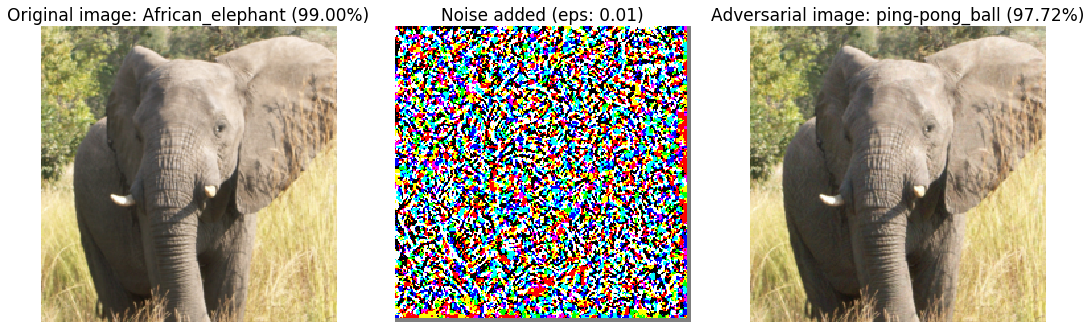

In [10]:
# Plot comparison
plot_comparison(result)

In [11]:
# Compare SHAP values between clean image and adversarial image

# Create the background data
X,y = shap.datasets.imagenet50()
X /= 255
X = torch.tensor(X.swapaxes(-1, 1).swapaxes(2, 3)).float()
X = X.to(device)

def generate_shap_comparison(model, adv_image, clean_image, device):
    """
    Generate SHAP value comparison between two images
    
    Args:
        model: A Pytorch model
        adv_image (numpy.array): The adversarial image
        clean_image (numpy.array): The original image
        device (str): ID of the device to allocate model and Tensors

    """
    adv_clean_images_pair = np.concatenate([np.expand_dims(clean_image, 0), 
                                            np.expand_dims(adv_image, 0)])
    adv_clean_images_pair = torch.tensor(adv_clean_images_pair).float()
    adv_clean_images_pair = adv_clean_images_pair.to(device)
    model = model.to(device)
    
    start = time.time()
    explainer = shap.GradientExplainer((model, model.Conv2d_4a_3x3), 
                                       X, local_smoothing=0.5)
    shap_values,indexes = explainer.shap_values(adv_clean_images_pair, 
                                                ranked_outputs=5, nsamples=200)
    end = time.time()
    
    logger.info('Computing SHAP values took {:.2f} seconds'.format(end - start))
        
    index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.data.cpu().numpy())
    
    shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
    shap.image_plot(shap_values, 
                    np.transpose(adv_clean_images_pair.data.cpu().numpy(), 
                                 [0, 2, 3, 1]), index_names, show=False)
    

### Now generate SHAP values for each image. Is there enough "evidence" to support the model's prediction on the adversarial image?

NB: Go take a coffee/tea while this runs! 
Generating SHAP values seems to take a long time, especially when running on CPU with higher values of `nsamples` in the `explainer.shap_values()` method. 
If you want this to run faster you can try 1) running on a GPU or 2) reducing `nsamples`.

2019-08-03 17:34:44,043 __main__     INFO     Computing SHAP values took 1265.80 seconds


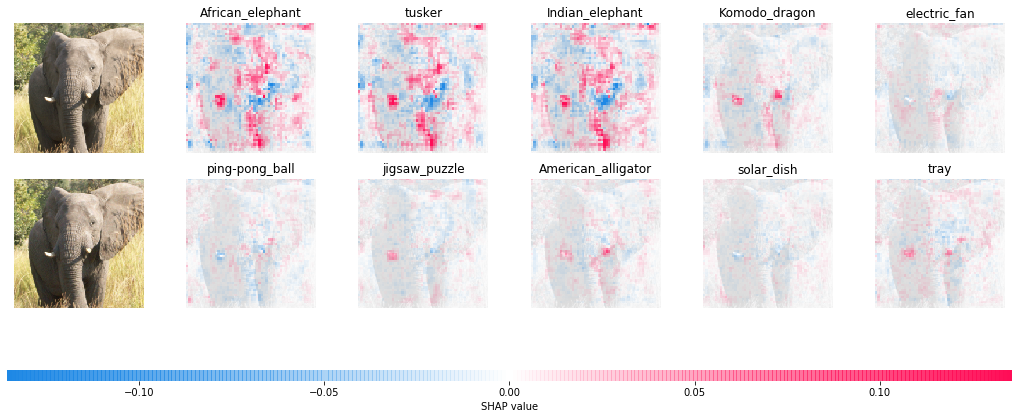

In [12]:
adv_image, clean_image, difference, adv_prob, clean_prob = result
generate_shap_comparison(model, adv_image, clean_image, device)

### For `African_elephant` and `ping-pong_ball`, there is a clear difference in SHAP values, and hence we can tell the original image from an adversarial one. What happens if we target a class that is semantically closer to the original image, say `Indian_elephant`?